1. Imports centralizados


In [1]:
import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torchaudio
import soundfile as sf

import re

from tqdm import tqdm

In [2]:
DATA_ROOT = Path("../EGFxSet")
OUT_DIR   = Path("./outputs_01_panns_base_egfxset")

OUT_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_ROOT exists:", DATA_ROOT.exists(), "->", DATA_ROOT)
print("OUT_DIR exists:", OUT_DIR.exists(), "->", OUT_DIR)

DATA_ROOT exists: True -> ../EGFxSet
OUT_DIR exists: True -> outputs_01_panns_base_egfxset


2. Semilla y carpeta de salida

Fija semilla (reproducibilidad) y define el directorio de salida de este experimento (02).

In [3]:
import os, random
from pathlib import Path
import numpy as np
import torch

OUT_DIR_BASE = Path("./outputs_01_panns_revisados_base_egfxset")
OUT_DIR_BASE.mkdir(parents=True, exist_ok=True)

SEED = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(SEED)
print("OUT_DIR_BASE:", OUT_DIR_BASE.resolve())


OUT_DIR_BASE: /Users/dtenreiro/Documents/TFM/panns_inference/outputs_01_panns_revisados_base_egfxset


## 3. Dispositivo

Selecciona `mps/cuda/cpu` igual que en el baseline.

In [4]:
device = (
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
device

if device == "cuda":
    print("CUDA device:", torch.cuda.get_device_name(0))
elif device == "mps":
    print("Apple Silicon MPS enabled")
else:
    print("CPU only")

Apple Silicon MPS enabled


4. Sincronización para benchmarks

Define `_sync()` para que las medidas de tiempo sean correctas en GPU/MPS.

In [5]:
import time
import numpy as np
import torch

def _sync():

    if device == "cuda" and torch.cuda.is_available():
        torch.cuda.synchronize()
    elif device == "mps" and hasattr(torch, "mps"):
        try:
            torch.mps.synchronize()
        except Exception:
            pass

def _summ(times_s, label=""):
    times = np.array(times_s, dtype=np.float64)
    return {
        "label": label,
        "n": int(times.size),
        "mean_ms": float(times.mean() * 1000),
        "p50_ms": float(np.percentile(times, 50) * 1000),
        "p95_ms": float(np.percentile(times, 95) * 1000),
        "min_ms": float(times.min() * 1000),
        "max_ms": float(times.max() * 1000),
        "runs_per_s": float(1.0 / times.mean()),
    }

2. Carga del índice del dataset

In [6]:
import pandas as pd
from pathlib import Path

INDEX_CSV_PATH = Path("../MERT/outputs_01_mert_base_egfxset/egfxset_index.csv")
assert INDEX_CSV_PATH.exists(), f"No encuentro {INDEX_CSV_PATH}. Ejecuta antes el notebook 01_PANNs_base_egfx."

df = pd.read_csv(INDEX_CSV_PATH)
print("Index:", df.shape)
df.head()


Index: (8947, 7)


,path,tone,pickup,tone_pickup,string,fret,midi_pitch
0,/Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...,BluesDriver,Bridge,BluesDriver__Bridge,1,0,64
1,/Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...,BluesDriver,Bridge,BluesDriver__Bridge,1,1,65
2,/Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...,BluesDriver,Bridge,BluesDriver__Bridge,1,10,74
3,/Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...,BluesDriver,Bridge,BluesDriver__Bridge,1,11,75
4,/Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...,BluesDriver,Bridge,BluesDriver__Bridge,1,12,76


1. Parámetros de audio y utilidades de pooling


In [7]:
MAX_SECONDS = 5.0
TARGET_SR = 32000

def load_audio_panns(path: str | Path):
    """Carga wav -> mono -> resample a 32kHz -> recorta a 5s"""
    wav, sr = sf.read(str(path))

    if wav.ndim == 2:
        wav = wav.mean(axis=1)

    wav = torch.from_numpy(wav).float()

    if sr != TARGET_SR:
        wav = torchaudio.functional.resample(wav, sr, TARGET_SR)
        sr = TARGET_SR

    wav = wav[: int(sr * MAX_SECONDS)]
    return wav, sr

2. Cargar PANNs CNN14


In [8]:
from pathlib import Path
import urllib.request

OUT = Path("pretrained_models")
OUT.mkdir(parents=True, exist_ok=True)

url = "https://zenodo.org/record/3987831/files/Cnn14_mAP%3D0.431.pth?download=1"
ckpt = OUT / "Cnn14_mAP=0.431.pth"

if not ckpt.exists():
    urllib.request.urlretrieve(url, ckpt)

PANNS_CNN14_CKPT = str(ckpt)
print("Checkpoint:", PANNS_CNN14_CKPT)

Checkpoint: pretrained_models/Cnn14_mAP=0.431.pth


In [9]:
from pathlib import Path
import os
import inspect
import torch
from panns_inference.models import Cnn14

def find_cnn14_ckpt() -> Path:

    env = os.environ.get("PANNS_CNN14_CKPT", "").strip()
    if env:
        p = Path(env).expanduser()
        if p.exists() and p.is_file():
            return p
        raise FileNotFoundError(f"PANNS_CNN14_CKPT apunta a algo que no es fichero: {p}")

    pkg_root = Path(inspect.getfile(Cnn14)).resolve().parent
    candidates = []
    for rel in [
        "../pretrained_models",
        "../pretrained",
        "../data",
        "../../pretrained_models",
        "../../pretrained",
    ]:
        d = (pkg_root / rel).resolve()
        if d.exists() and d.is_dir():
            candidates += list(d.rglob("*.pth"))

    candidates = sorted(candidates, key=lambda p: (("cnn14" not in p.name.lower()), len(p.name)))
    if candidates:
        return candidates[0]

    raise FileNotFoundError(
        "No se ha encontrado ningún checkpoint .pth de PANNs CNN14.\n"
    )

CKPT = find_cnn14_ckpt()
print("Using checkpoint:", CKPT)

panns_model = Cnn14(
    sample_rate=TARGET_SR,
    window_size=1024,
    hop_size=320,
    mel_bins=64,
    fmin=50,
    fmax=14000,
    classes_num=527
)

ckpt = torch.load(CKPT, map_location=device)
state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
panns_model.load_state_dict(state, strict=True)

panns_model.to(device).eval()
print("Loaded PANNs:", panns_model.__class__.__name__, "on", device)

Using checkpoint: /Users/dtenreiro/Documents/TFM/panns_inference/pretrained_models/Cnn14_mAP=0.431.pth
Loaded PANNs: Cnn14 on mps


3. Extracción de embeddings baseline


In [10]:
OUT_DIR_BASE = Path("./outputs_01_panns_revisados_base_egfxset")
OUT_DIR_BASE.mkdir(parents=True, exist_ok=True)

def extract_panns_base_embedding(path):
    """Embedding global de PANNs (pooling interno del modelo)."""
    x, _ = load_audio_panns(path)
    x = x.to(device).unsqueeze(0)

    with torch.no_grad():
        out = panns_model(x, None)

    emb = out["embedding"].squeeze(0).float().cpu()
    return emb

In [11]:
from tqdm import tqdm
import numpy as np

paths = df["path"].tolist()
N = len(paths)

v0 = extract_panns_base_embedding(paths[0])
D = int(v0.numel())

out_path = OUT_DIR_BASE / "embeddings_panns_base_global.npy"
mm = np.memmap(out_path, dtype=np.float32, mode="w+", shape=(N, D))
mm[0] = v0.numpy().astype(np.float32)

for i, path in enumerate(tqdm(paths[1:], desc="Extracting PANNs baseline embeddings"), start=1):
    mm[i] = extract_panns_base_embedding(path).numpy().astype(np.float32)

mm.flush()
print("Saved:", out_path, "| shape:", (N, D))

Extracting PANNs baseline embeddings: 100%|█| 8946/8946 [01:06<00:00, 135.20it/s

Saved: outputs_01_panns_revisados_base_egfxset/embeddings_panns_base_global.npy | shape: (8947, 2048)


4. Evaluación (Top-1 / Top-5) en validación


In [12]:
# Fallback robusto: reconstruir val_idx si no existe
if "val_idx" not in globals():
    from sklearn.model_selection import train_test_split
    _labels_split = df["tone_pickup"].astype(str)
    _idx = np.arange(len(df), dtype=int)
    _, val_idx = train_test_split(
        _idx,
        test_size=0.20,
        random_state=SEED,
        stratify=_labels_split
    )
    val_idx = np.asarray(val_idx, dtype=int)

import numpy as np
import pandas as pd

def l2_normalize(X: np.ndarray, eps: float = 1e-9) -> np.ndarray:
    n = np.linalg.norm(X, axis=1, keepdims=True)
    return X / (n + eps)

labels_all = df["tone_pickup"].astype(str).to_numpy()
labels = labels_all[val_idx]
N = len(labels)

emb_path = OUT_DIR_BASE / "embeddings_panns_base_global.npy"
assert emb_path.exists(), f"No existe: {emb_path}"
print("Evaluating:", emb_path.name)
print("Evaluating on VAL only:", N, "samples")

X = np.memmap(emb_path, dtype=np.float32, mode="r").reshape(len(df), -1)
X = l2_normalize(X)
Xv = X[val_idx]

Sv = Xv @ Xv.T
np.fill_diagonal(Sv, -np.inf)

nn1 = np.argmax(Sv, axis=1)
top1 = (labels[nn1] == labels).mean()

k = min(5, N - 1)
nnk = np.argpartition(-Sv, kth=k, axis=1)[:, :k]
top5 = np.array([labels[i] in labels[nnk[r]] for r, i in enumerate(range(N))]).mean()

res_df = pd.DataFrame([{
    "file": emb_path.name,
    "dim": Xv.shape[1],
    "top1": float(top1),
    "top5": float(top5),
    "eval_set": "val",
    "n_eval": int(N),
}])
res_df


Evaluating: embeddings_panns_base_global.npy
Evaluating on VAL only: 1790 samples


,file,dim,top1,top5,eval_set,n_eval
0,embeddings_panns_base_global.npy,2048,0.394413,0.763687,val,1790


In [13]:
if "N_CLASSES" not in globals():
    N_CLASSES = int(df["tone_pickup"].astype(str).nunique())

chance = 1.0 / N_CLASSES
res_df_eval = res_df.copy()
res_df_eval["chance"] = chance
res_df_eval["top1_vs_chance"] = res_df_eval["top1"] / chance
res_df_eval = res_df_eval.sort_values(["top1", "top5"], ascending=False)
res_df_eval


,file,dim,top1,top5,eval_set,n_eval,chance,top1_vs_chance
0,embeddings_panns_base_global.npy,2048,0.394413,0.763687,val,1790,0.015385,25.636872


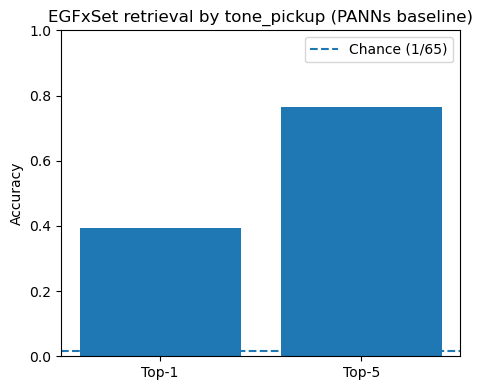

In [14]:
import numpy as np
import matplotlib.pyplot as plt

row = res_df_eval.iloc[0]

plt.figure(figsize=(4.8, 4))
plt.bar(["Top-1", "Top-5"], [row["top1"], row["top5"]])
plt.axhline(float(row["chance"]), linestyle="--", label=f"Chance (1/{int(round(1/row['chance']))})")
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("EGFxSet retrieval by tone_pickup (PANNs baseline)")
plt.legend()
plt.tight_layout()
plt.show()

Best embedding (by VAL): embeddings_panns_base_global.npy


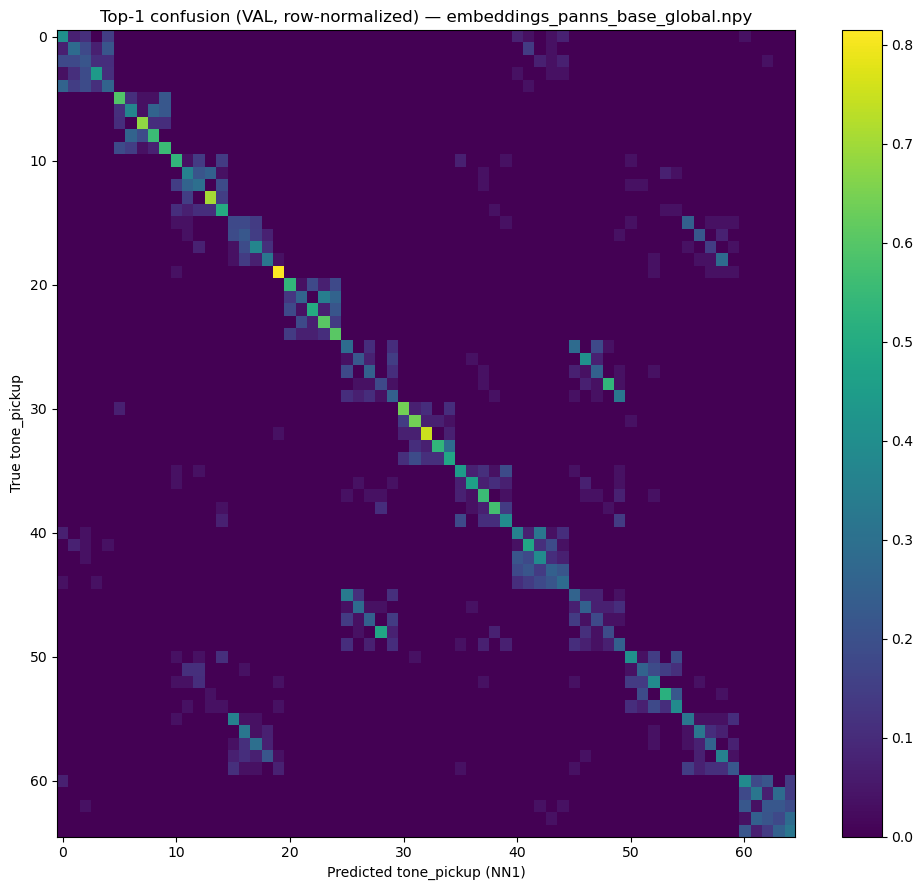

,row_0,col_0,count
0,Hall Reverb__Middle-Neck,Spring Reverb__Middle-Neck,15
1,Spring Reverb__Middle-Neck,Hall Reverb__Middle-Neck,13
2,Hall Reverb__Bridge-Middle,Spring Reverb__Bridge-Middle,11
3,TapeEcho__Bridge,Digital Delay__Bridge,10
4,TapeEcho__Bridge-Middle,Digital Delay__Bridge-Middle,9
5,Spring Reverb__Bridge,Hall Reverb__Bridge,9
6,RAT__Bridge,RAT__Middle,9
7,Hall Reverb__Neck,Spring Reverb__Neck,9
8,Hall Reverb__Bridge,Spring Reverb__Bridge,8
9,Flanger__Bridge-Middle,Flanger__Middle-Neck,8


In [15]:
# Fallback robusto: reconstruir val_idx si no existe
if "val_idx" not in globals():
    from sklearn.model_selection import train_test_split
    _labels_split = df["tone_pickup"].astype(str)
    _idx = np.arange(len(df), dtype=int)
    _, val_idx = train_test_split(
        _idx,
        test_size=0.20,
        random_state=SEED,
        stratify=_labels_split
    )
    val_idx = np.asarray(val_idx, dtype=int)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

best_file = res_df_eval.sort_values(["top1", "top5"], ascending=False).iloc[0]["file"]
best_path = OUT_DIR_BASE / best_file
print("Best embedding (by VAL):", best_file)

X = np.memmap(best_path, dtype=np.float32, mode="r").reshape(len(df), -1)
labels_all = df["tone_pickup"].astype(str).to_numpy()

Xv = X[val_idx]
y_true = labels_all[val_idx]
assert Xv.shape[0] == len(y_true)

Xv = Xv / (np.linalg.norm(Xv, axis=1, keepdims=True) + 1e-9)
Sv = Xv @ Xv.T
np.fill_diagonal(Sv, -np.inf)
nn1 = np.argmax(Sv, axis=1)
y_pred = y_true[nn1]

cm = pd.crosstab(y_true, y_pred)  # filas: true, columnas: pred
cm = cm.reindex(index=sorted(cm.index), columns=sorted(cm.columns), fill_value=0)
cm_norm = cm.div(cm.sum(axis=1).replace(0, 1), axis=0)  # por fila

plt.figure(figsize=(10, 9))
plt.imshow(cm_norm.to_numpy(), aspect="auto")
plt.title(f"Top-1 confusion (VAL, row-normalized) — {best_file}")
plt.xlabel("Predicted tone_pickup (NN1)")
plt.ylabel("True tone_pickup")
plt.colorbar()
plt.tight_layout()
plt.show()

cm_off = cm.copy()
for k in cm_off.index:
    if k in cm_off.columns:
        cm_off.loc[k, k] = 0

top_conf = (
    cm_off.stack()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
    .rename(columns={"level_0":"true", "level_1":"pred", 0:"count"})
)
top_conf


In [16]:
tabla = res_df_eval.copy()

tabla["Configuración"] = tabla["file"]
tabla["Modelo"] = "PANNs CNN14 baseline"
tabla["Capas usadas"] = "Global (interno)"
tabla["Pooling de capas"] = "Global pooling (modelo)"
tabla["Dimensión"] = tabla["dim"]
tabla["Top-1"] = tabla["top1"].round(3)
tabla["Top-5"] = tabla["top5"].round(3)
tabla["Veces mejor que azar"] = tabla["top1_vs_chance"].round(1)

tabla_final = tabla[
    ["Configuración", "Modelo", "Capas usadas", "Pooling de capas",
     "Dimensión", "Top-1", "Top-5", "Veces mejor que azar"]
].sort_values("Top-1", ascending=False)

tabla_final

,Configuración,Modelo,Capas usadas,Pooling de capas,Dimensión,Top-1,Top-5,Veces mejor que azar
0,embeddings_panns_base_global.npy,PANNs CNN14 baseline,Global (interno),Global pooling (modelo),2048,0.394,0.764,25.6


Usando best_file: embeddings_panns_base_global.npy | VAL top1=0.3944 | VAL top5=0.7637


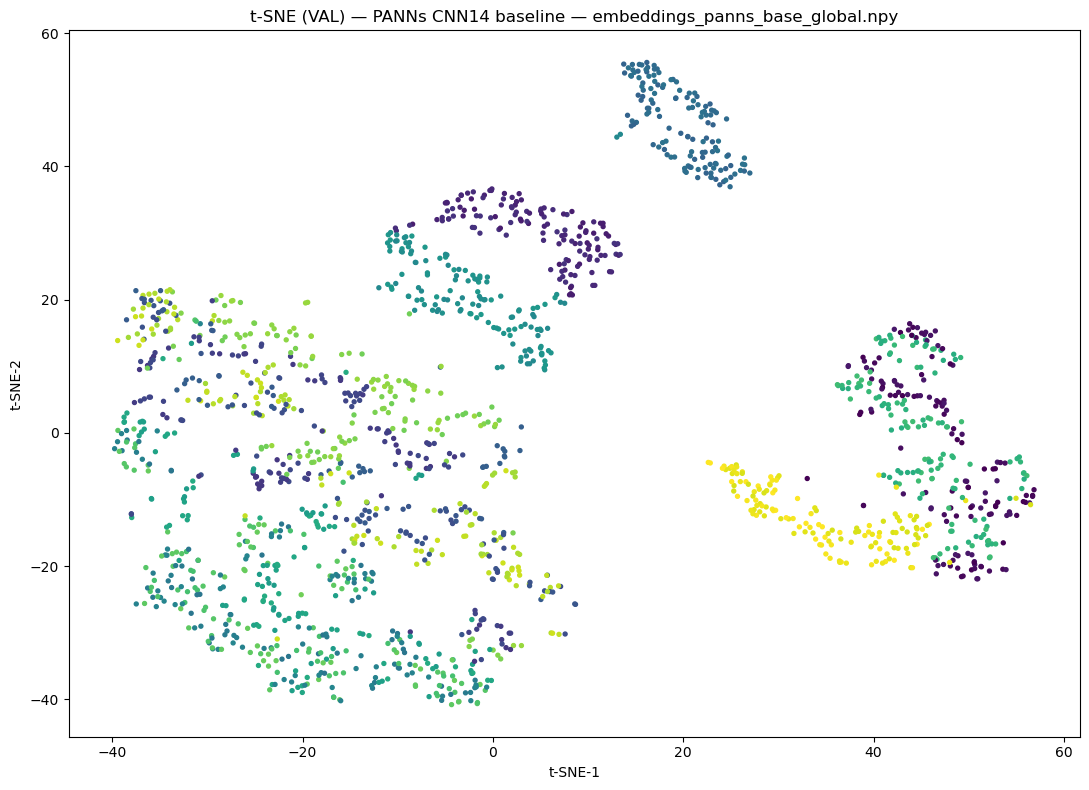

In [17]:
# Fallback robusto: reconstruir val_idx si no existe
if "val_idx" not in globals():
    from sklearn.model_selection import train_test_split
    _labels_split = df["tone_pickup"].astype(str)
    _idx = np.arange(len(df), dtype=int)
    _, val_idx = train_test_split(
        _idx,
        test_size=0.20,
        random_state=SEED,
        stratify=_labels_split
    )
    val_idx = np.asarray(val_idx, dtype=int)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

best_row = res_df_eval.sort_values(["top1", "top5"], ascending=False).iloc[0]
best_file = best_row["file"]
best_top1 = best_row["top1"]
best_top5 = best_row["top5"]

best_path = OUT_DIR_BASE / best_file
print(f"Usando best_file: {best_file} | VAL top1={best_top1:.4f} | VAL top5={best_top5:.4f}")

X = np.memmap(best_path, dtype=np.float32, mode="r").reshape(len(df), -1)
labels_all = df["tone_pickup"].astype(str).to_numpy()

X = X[val_idx]
labels = labels_all[val_idx]

X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)

pca_dim = min(50, X.shape[1])
X_pca = PCA(n_components=pca_dim, random_state=42).fit_transform(X)

N = X_pca.shape[0]
perplexity = max(5, min(30, (N - 1) // 3))

tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    init="pca",
    learning_rate="auto",
    random_state=42,
)
Z = tsne.fit_transform(X_pca)

uniq = sorted(set(labels.tolist()))
lab2i = {u:i for i,u in enumerate(uniq)}
c = np.array([lab2i[x] for x in labels], dtype=int)

plt.figure(figsize=(11, 8))
plt.scatter(Z[:, 0], Z[:, 1], c=c, s=8)
plt.title(f"t-SNE (VAL) — PANNs CNN14 baseline — {best_file}")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.tight_layout()
plt.show()


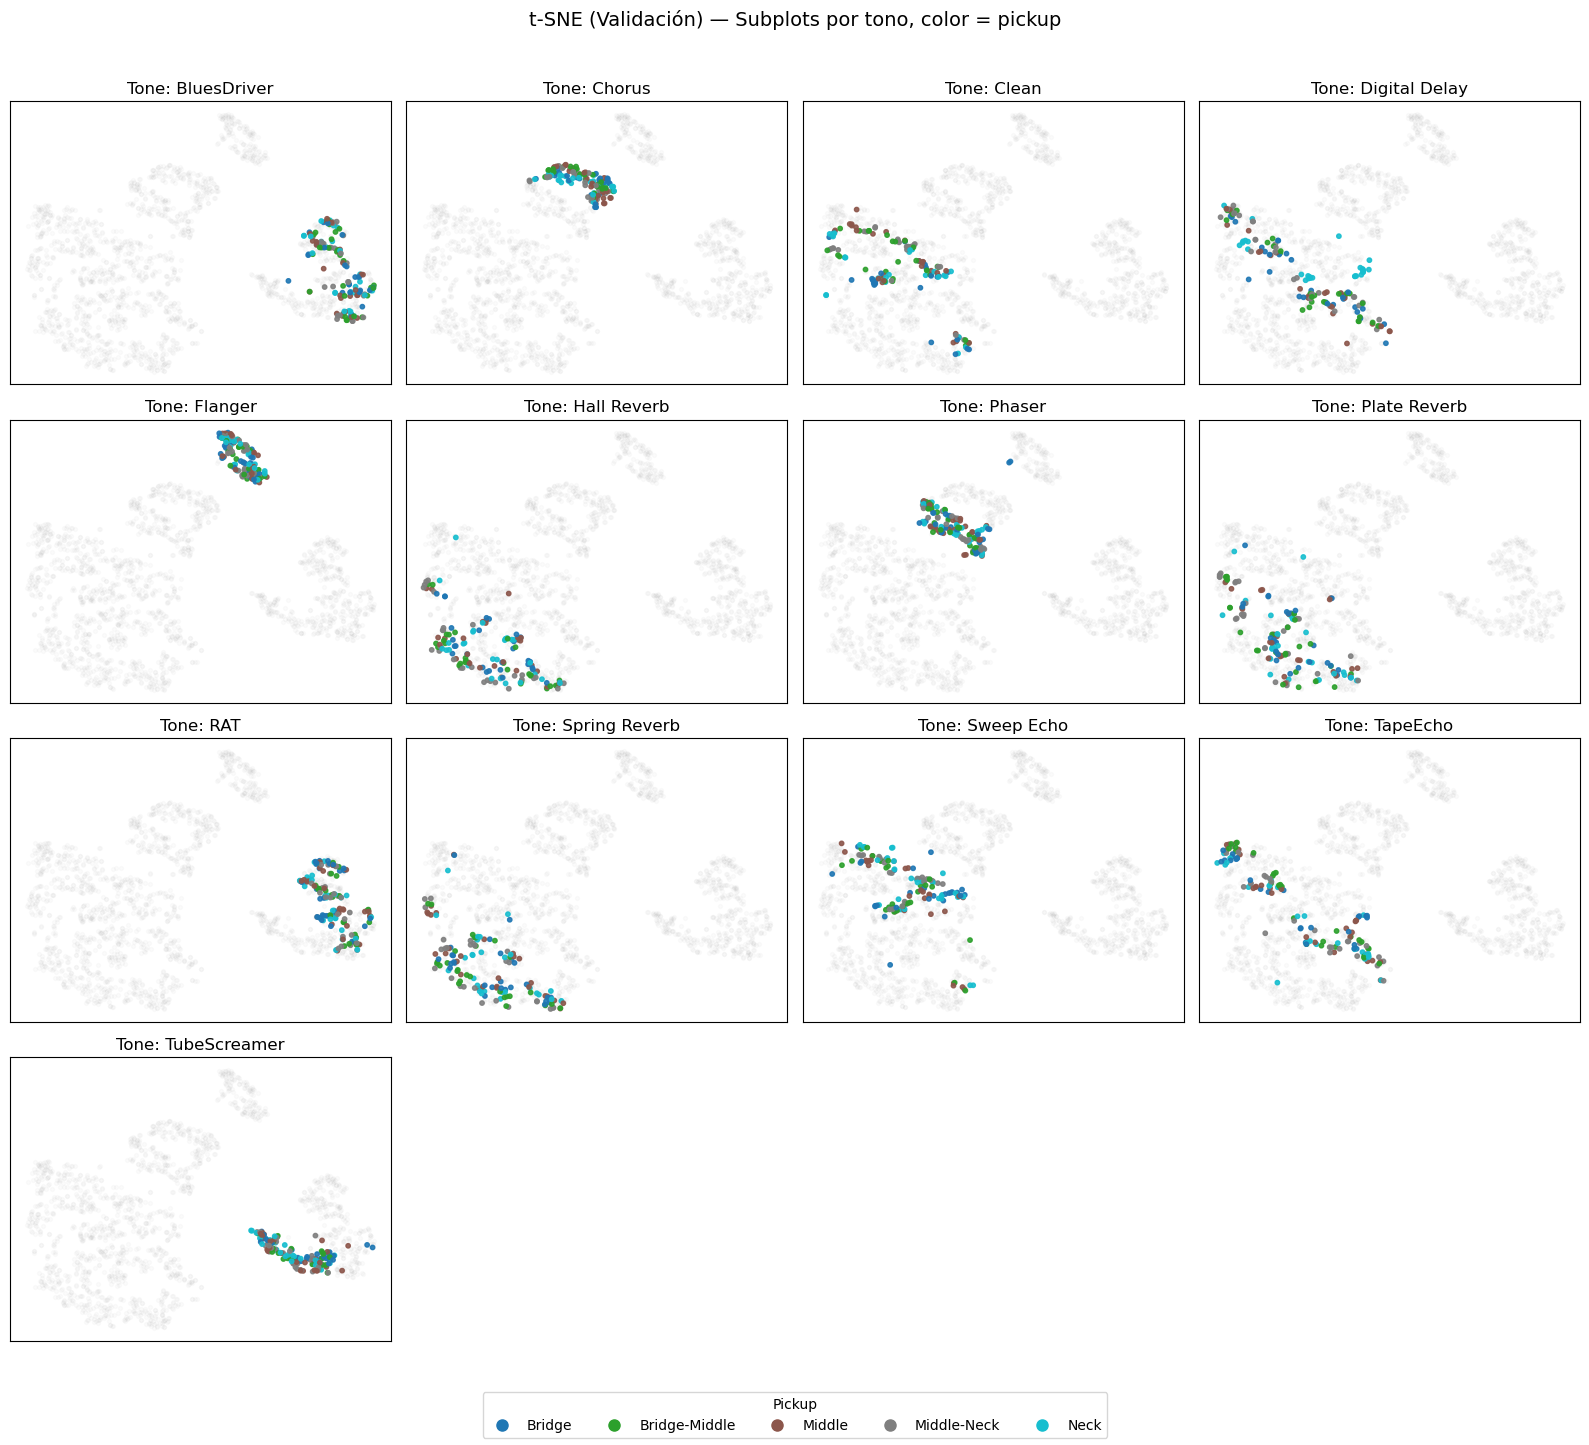

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Elegir Z existente
if "Z_val" in globals():
    Z_used = Z_val
elif "Z" in globals():
    Z_used = Z
else:
    raise NameError("No existe ni Z_val ni Z. Calcula el t-SNE antes (variable típica: Z).")

if "val_idx" not in globals():
    raise NameError("No existe val_idx. Necesito val_idx para alinear df con el t-SNE de validación.")

df_val = df.iloc[val_idx].copy().reset_index(drop=True)

assert Z_used.shape[0] == len(df_val), (
    f"El t-SNE tiene {Z_used.shape[0]} filas pero df_val tiene {len(df_val)}.\n"
    "Z debe corresponder a validación (mismo orden que val_idx)."
)

pickups = sorted(df_val["pickup"].astype(str).unique().tolist())
pickup_to_id = {p: i for i, p in enumerate(pickups)}
pickup_ids = df_val["pickup"].astype(str).map(pickup_to_id).to_numpy()

from matplotlib import colormaps
cmap = colormaps.get_cmap("tab10").resampled(max(len(pickups), 1))

tones = sorted(df_val["tone"].astype(str).unique().tolist())
n_tones = len(tones)

ncols = int(np.ceil(np.sqrt(n_tones)))
nrows = int(np.ceil(n_tones / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.6*nrows), squeeze=False)
axes = axes.ravel()

tone_arr = df_val["tone"].astype(str).to_numpy()

for i, t in enumerate(tones):
    ax = axes[i]
    m = (tone_arr == t)

    ax.scatter(Z_used[~m, 0], Z_used[~m, 1], s=8, alpha=0.03, color="grey")

    ax.scatter(
        Z_used[m, 0], Z_used[m, 1],
        c=pickup_ids[m],
        cmap=cmap,
        s=10, alpha=0.9,
        vmin=0, vmax=max(len(pickups)-1, 0)
    )

    ax.set_title(f"Tone: {t}")
    ax.set_xticks([]); ax.set_yticks([])

for j in range(n_tones, len(axes)):
    axes[j].axis("off")

legend_handles = [
    Line2D([0], [0], marker='o', linestyle='',
           markerfacecolor=cmap(i), markeredgecolor=cmap(i),
           markersize=8, label=p)
    for i, p in enumerate(pickups)
]
fig.legend(handles=legend_handles, title="Pickup",
           loc="lower center", ncol=min(len(pickups), 6))

fig.suptitle("t-SNE (Validación) — Subplots por tono, color = pickup", y=0.995, fontsize=14)
plt.tight_layout(rect=[0, 0.06, 1, 0.98])
plt.show()


6. Métricas de inferencia (PANNs baseline)


In [19]:
import time
import numpy as np
import torch

if '_sync' not in globals():
    def _sync():
        if device == 'cuda' and torch.cuda.is_available():
            torch.cuda.synchronize()
        elif device == 'mps' and hasattr(torch, 'mps'):
            try:
                torch.mps.synchronize()
            except Exception:
                pass

if '_summ' not in globals():
    def _summ(times_s, label=''):
        times = np.array(times_s, dtype=np.float64)
        return {
            'label': label,
            'n': int(times.size),
            'mean_ms': float(times.mean() * 1000),
            'p50_ms': float(np.percentile(times, 50) * 1000),
            'p95_ms': float(np.percentile(times, 95) * 1000),
            'min_ms': float(times.min() * 1000),
            'max_ms': float(times.max() * 1000),
            'runs_per_s': float(1.0 / times.mean()) if times.mean() > 0 else float('inf'),
        }

paths_bench = df['path'].astype(str).tolist()

n_warmup = 10
n_runs = min(50, len(paths_bench))

for pth in paths_bench[:n_warmup]:
    _ = extract_panns_base_embedding(pth)

times = []
for pth in paths_bench[:n_runs]:
    _sync()
    t0 = time.perf_counter()
    _ = extract_panns_base_embedding(pth)
    _sync()
    t1 = time.perf_counter()
    times.append(t1 - t0)

stats_panns_e2e = _summ(times, label='PANNs baseline E2E (load+resample+forward+pool)')

# B) FORWARD ONLY: panns_model(x)
p0 = paths_bench[0]
wav0, _ = load_audio_panns(p0)
x0 = wav0.to(device).unsqueeze(0)
panns_model.eval()

n_warmup = 30
n_runs = 200

with torch.inference_mode():
    for _ in range(n_warmup):
        _ = panns_model(x0, None)
    _sync()

    times = []
    for _ in range(n_runs):
        _sync()
        t0 = time.perf_counter()
        _ = panns_model(x0, None)
        _sync()
        t1 = time.perf_counter()
        times.append(t1 - t0)

stats_panns_forward = _summ(times, label='PANNs baseline FORWARD ONLY (panns_model(x))')

stats_panns_e2e, stats_panns_forward

({'label': 'PANNs baseline E2E (load+resample+forward+pool)',
  'n': 50,
  'mean_ms': 7.562370060077228,
  'p50_ms': 7.404770500215818,
  'p95_ms': 9.51859550050358,
  'min_ms': 6.59691699911491,
  'max_ms': 10.239582999929553,
  'runs_per_s': 132.23367701603692},
 {'label': 'PANNs baseline FORWARD ONLY (panns_model(x))',
  'n': 200,
  'mean_ms': 4.307523965071596,
  'p50_ms': 4.3009999999412685,
  'p95_ms': 4.3908062511036405,
  'min_ms': 4.253542001606547,
  'max_ms': 4.459583000425482,
  'runs_per_s': 232.15192953276554})